In [2]:
import sqlite3
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn import preprocessing
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import QuantileTransformer
#import statsmodels.api as sm
from sklearn.decomposition import PCA
import matplotlib.colors
from sklearn.cluster import KMeans
import seaborn as sns
import matplotlib.colors
from kmodes.kmodes import KModes
from matplotlib.ticker import FuncFormatter
import pandas as pd
import scipy
from scipy.cluster import hierarchy

In [162]:
#!pip install kmodes

twisted 18.7.0 requires PyHamcrest>=1.9.0, which is not installed.
distributed 1.21.8 requires msgpack, which is not installed.
You are using pip version 10.0.1, however version 18.1 is available.
You should consider upgrading via the 'python -m pip install --upgrade pip' command.


In [3]:
def premium_proportion():
    """
    Returns:
    -> all premiums as proportion of sum_premiums
    -> engagement = sum_premiums/month_salary
    -> balance = abs(sum_premiums)/(sum(abs(premiums)))
    """
    premiums = ['premium_house', 'premium_life', 'premium_work', 'premium_health', 'premium_motor']
    
    df['sum_premiums']=0
    for s in premiums:
        df['sum_premiums']+=df.loc[:,s]
    df['balance']=0
    for p in premiums:
        df['balance']+=abs(df.loc[:,p])
    df['balance']=df['sum_premiums']/df['balance']
    for s in premiums:
        df.loc[:,s] /= df['sum_premiums']
    df['engagement'] = df['sum_premiums']/df['month_salary']
    return df

## Variable Transformations

In [4]:
def standard_scaling(df):
    """
    Returns data frame with data scaled with z-score
    """
    scaler = preprocessing.StandardScaler()
    scaled_df = scaler.fit_transform(df)
    scaled_df = pd.DataFrame(scaled_df, columns = df.columns, index = df.index.get_values())
    return scaled_df

def robust_scaling(df):
    return RobustScaler(quantile_range=(25, 75)).fit_transform(df)

def min_max_scaling(df):
    return MinMaxScaler().fit_transform(df)

def normal_scaling(df):
    return Normalizer().fit_transform(df)

def quantile_transformer_scaling(df):
    return QuantileTransformer(output_distribution='uniform').fit_transform(df)

def quantile_normal_scaling(df):
    return QuantileTransformer(output_distribution='normal').fit_transform(df)

# Names of the scaling functions defined above + their names to label the plots
scaling_functions=['standard_scaling', 'robust_scaling', 'min_max_scaling', 'normal_scaling',
                   'quantile_transformer_scaling', 'quantile_normal_scaling']
scaling_functions_names = ['Standard', 'Robust', 'Min-Max', 'Normalizing', 'Quantile Transformer',
                           'Quantile Transformer (Normal)']

def call_scaling_function(df, name_function):
    """
    Returns the data frame with the scaling method you specified
    """
    if name_function == scaling_functions[0]:
        scaled_df=standard_scaling(df)
    elif name_function == scaling_functions[1]:
        scaled_df = robust_scaling(df)
    elif name_function == scaling_functions[2]:
        scaled_df = min_max_scaling(df)
    elif name_function == scaling_functions[3]:
        scaled_df=normal_scaling(df)
    elif name_function==scaling_functions[4]:
        scaled_df=quantile_transformer_scaling(df)
    else:
        scaled_df=quantile_normal_scaling(df)
    return pd.DataFrame(scaled_df, index=df.index.get_values(), columns=df.columns)

def encode_variables(df):
    """
    returns a data frame with hot encoding
    """
    df['area_he'] = pd.Categorical(data_pca['living_area'])
    df['children_he'] = pd.Categorical(df['Children'])
    
    df_area = pd.get_dummies(data_pca['area_he'], prefix = 'categ')
    df_child = pd.get_dummies(data_pca['children_he'], prefix = 'categ')
    
    df_child.columns = ['No Children', 'Children']
    df_area.columns = ['A1', 'A2', 'A3', 'A4']
    return pd.concat([df_child, df_area], axis = 1)

def define_group_variables(df):
    
    """
    Returns :three groups of variables: consume, engagement and categorical
    """
    consume = list(['premium_house', 'premium_health', 'premium_life', 'premium_work', 'premium_motor'])
    categorical = list(['living_area', 'Children'])
    engagement=list(df.columns)
    for v in (consume):
        engagement.remove(v)
    for v in (categorical):
        engagement.remove(v)
    return engagement, consume, categorical

def grouped_data_frames(df):
    """
    Returns data frames grouped by engagement, consume and categorical, respectively
    """
    df_engagement=df.loc[:,engagement]
    df_consume=df.loc[:,consume]
    df_categorical=df.loc[:,categorical]
    return df_engagement, df_consume, df_categorical

### Apply PCA with all scaling functions to see which fits best

In [5]:
def pca_scaling(df, title_legend):
    fig = plt.figure(figsize=(6,4))
    ax = plt.subplot2grid((1,1), (0,0))

    for i,s in enumerate(scaling_functions):
        pca = PCA(0.9)
        df_scaled=call_scaling_function(df, s)
        components = pca.fit_transform(df_scaled)
        y1=pca.explained_variance_ratio_
        y3 = y1.cumsum()
        plt.scatter([(i+1) for i in range((len(y1)))], y3, label=scaling_functions_names[i])
        
        ax.set_xticks([i for i in range(1,len(y3))])
        ax.legend(loc=0)
        ax.grid(linestyle = 'dashed')
        ax.set_xlabel('Principal Components', fontsize=12)
        ax.set_ylabel('Cumulative Sum of\nExplained Variance ratio', fontsize=12)
        ax.set_title('Explained Variance of %s Variables'%title_legend, color='firebrick', fontsize=14)
        ax.set_xticklabels([i for i in range(1,7)])
    ax.set_xticks([i for i in range(1,7)])
    plt.savefig('pca_%s'%title_legend)
    
def create_kmeans_clusters(df, principal_components):
    """
    Will run k-means with 1-max_clusters, and draw the elbow graph
    """
    max_clusters=20
    number_clusters=1
    result_kmeans = pd.DataFrame(columns=['inertia', 'error'], index=[i for i in range(1,max_clusters)])

    while max_clusters>=number_clusters:
        kmeans=KMeans(n_clusters=number_clusters, max_iter=1000, n_init=10).fit((principal_components))
        kmeans.fit(principal_components)
        inertia=kmeans.inertia_
        result_kmeans.loc[number_clusters, 'inertia']=inertia
        if number_clusters==1:
            max_error=inertia
            result_kmeans.loc[number_clusters, 'error']=0
        else:
            result_kmeans.loc[number_clusters, 'error']=1-inertia/max_error
        number_clusters+=1
    
    return [i for i in range(1,max_clusters+1)], pd.DataFrame(result_kmeans['inertia'])

def elbow_graph_scaling(df, title_legend, scaling_functions):
    n_labels = len(scaling_functions)
    cmap = plt.get_cmap("viridis", n_labels)
    fig =plt.figure(figsize=(10,4))
    ax=plt.subplot2grid((1,2),(0,0))
    #ax2=plt.subplot2grid((1,3),(0,1))
    ax3=plt.subplot2grid((1,2),(0,1))
    for i, s in enumerate(scaling_functions):
        df2=call_scaling_function(df, s)
        
        x, inertia_values=create_kmeans_clusters(df2, df2)
        if i<=1:
            #ax.scatter(x, inertia_values, color=cmap(i), label=scaling_functions_names[i])
            ax.scatter(x, inertia_values, color='firebrick')

        else:
            ax2.scatter(x, inertia_values, color=cmap(i), label=scaling_functions_names[i])

        error=inertia_values/inertia_values.max()
        rsq=1-error
        #ax3.scatter(x, rsq, color=cmap(i))
        ax3.scatter(x, rsq, color='firebrick')
        ax.set_xlabel('Number Of Clusters', fontsize=12)
        ax.set_ylabel('Inertia', fontsize=12)
        ax3.set_ylabel('RSQ', fontsize=12)
        ax.set_title('Inertia in K-Means Method for \n %s Variables'%title_legend, fontsize=14)
        xticks=[i for i in range(0,22,2)]
        ax.set_xticks(xticks)
        #ax2.set_xticks(xticks)
        ax3.set_xticks(xticks)
        ax3.set_yticks([i/10 for i in range(0,11)])
        ax.ticklabel_format(style='sci', axis='y', scilimits=(1,4), useMathText=True, fontsize=12)
        #ax2.ticklabel_format(style='sci', axis='y', scilimits=(1,2), useMathText=True, fontsize=12)
        ax.grid(linestyle='dashed', color='gray')
        #ax2.grid(linestyle='dashed', color='gray')
        ax3.grid(linestyle='dashed', color='gray')
        #ax.legend(loc=0)
        #ax2.legend(loc=0)
        fig.tight_layout()

### Elbow graph for k-modes

In [6]:
def elbow_graph_kmodes(df):
    number_clusters=1
    max_number_clusters = 8
    cost = []
    while number_clusters<=max_number_clusters:
        km = KModes(n_clusters=number_clusters, init='Huang', n_init=10, verbose=1)
        clusters_categorical = km.fit(df)
        cost.append(clusters_categorical.cost_)
        number_clusters+=1
    return clusters_categorical, cost, [i for i in range(1,(max_number_clusters+1))]

### Building the final data frame 

In [7]:
def columns_clusters(df, number_clusters, init_number, group_variables, name_column):
    """
    Applies k-means method and returns the data frame with a column with the labels of the clusters
    for each data point
    """
    kmeans = KMeans(n_clusters=number_clusters, n_init=init_number, max_iter=1000).fit((group_variables))
    kmeans_centers=kmeans.cluster_centers_
    clusters_labels=kmeans.predict(group_variables)
    kmeans_df=pd.DataFrame(clusters_labels, index=group_variables.index.get_values())
    df.insert(df.shape[1], name_column, kmeans_df)
    return df, kmeans_centers

def define_label(df, labels1, labels2, labels3):
    """
    Defines final labels as combination from labels1 and labels2
    
    df -> dataframe already with labels
    labels1, labels2 -> names of columns with labels to be combined
    labels3 -> name of the resulting column
    """
    k=0
    count=0
    df[labels3]=''
    for i in list(df[labels1].unique()):
        for j in list(df[labels2].unique()):
            mask1=df.loc[:,labels1]==i
            mask2=df.loc[:,labels2]==j
            df.loc[:,labels3][mask1 & mask2]=k
            k+=1
    return df

def remove_outliers(df1, df2, name_column, outliers):
    """
    Removes rows specified by a label (outliers) in the column name_column
    and returns the new data frame
    """
    for i in outliers:
        df1=df1[df2[name_column]!=i]
    return df1

### Hierarchical Clustering to define which points to remove:

In [17]:
def hierarchical_clustering_centroids(df, index_array, name_column):
    """
    Returns the centroids of the clusters that matter as a data frame, to be used in hierarchical clustering
    """
    df_hierarchical=pd.DataFrame(columns=df.drop(name_column, axis=1).columns, index=index_array)
    for i in index_array:
        for j in df.columns:
            df_hierarchical.loc[i,j]=df[j][df[name_column]==i].mean()
            
    return df_hierarchical

def plot_dendrogram(df, title, name_plot):
    Z = hierarchy.linkage(df_hierarchical, method = 'ward')#method='single, complete
    fig=plt.figure(figsize=(6,4))
    ax=plt.subplot2grid((1,1),(0,0))
    hierarchy.dendrogram(Z,orientation = 'top',leaf_rotation=45.,leaf_font_size=10.,
        show_contracted=True,show_leaf_counts=True,labels=df_hierarchical.index.get_values())
    ax.set_title('Hierarchical Clustering from \n%s'%title)
    plt.savefig('report\%s'%name_plot)
    
def get_array_labels(size, index_array, min_points):
    array_labels=pd.DataFrame(size, index=index_array)
    for i,j in enumerate(array_labels.iloc[:,-1]):
        if j<100:
            array_labels=array_labels[array_labels.iloc[:,-1]!=j]
    return array_labels

## Plots

In [18]:
def print_size_clusters(df, array_labels, column_labels, print_bool):
    sum_count=0
    count_clusters=[]
    print('label|#points')
    for i,j in enumerate(array_labels):
        counts=df[df[column_labels]==j]
        count_clusters.append(len(counts))
        if(print_bool):
            print(j, len(counts))
        sum_count+=len(counts)
    return count_clusters

def plot_clusters(df, array_labels, labels_columns_name, var1, var2, i1, i2, var1_name, var2_name, save_as,
                  x1, y1, x2, y2):
    fig=plt.figure(figsize=(10,4))
    ax=plt.subplot2grid((1,2), (0,0))
    ax2=plt.subplot2grid((1,2), (0,1))
    
    cmap = plt.get_cmap("viridis", len(array_labels[:]))
    for i,j in enumerate(array_labels[:]):
        if ((i<=len(array_labels))):
            ax.scatter(df.loc[:,var1][df[labels_columns_name]==j],
                   df.loc[:,var2][df[labels_columns_name]==j], label='C%d'%(i+1), color=cmap(i),
                      edgecolor='black', linewidth=0.25)
        if ((i==i1)|(i==i2)):
            ax2.scatter(df.loc[:,var1][df[labels_columns_name]==j],
               df.loc[:,var2][df[labels_columns_name]==j], label='C%d'%(i+1), color=cmap(i),
                       edgecolor='black', linewidth=0.25)
        ax.legend(loc=0)
        ax.set_xlabel('%s'%var1_name, fontsize=12)
        ax.set_ylabel('%s'%var2_name, fontsize=12)
        ax.grid(linestyle='dashed', color='gray', alpha=0.35)
        ax2.grid(linestyle='dashed', color='gray', alpha=0.35)
        ax.set_xlim(x1)
        ax2.set_xlim(x2)
        ax.set_ylim(y1)
        ax2.set_ylim(y2)
        
    plt.savefig('%s'%save_as)
    
def plot_size_clusters(array_labels, plot_name, yticks):
    fig=plt.figure(figsize=(6,4))
    ax=plt.subplot2grid((1,1),(0,0))
    x=[(i+1) for i in range(0,len(array_labels))]
    ax.bar(x, array_labels, color='darkslategray', edgecolor='black')
    ax.set_title('Size of each Cluster', fontsize=12)
    ax.set_xticklabels('C%d'%(i+1) for i in range(0,len(array_labels)))
    ax.set_xticks([(i+1) for i in range(0,len(array_labels))])
    ax.set_yticks(yticks)
    plt.savefig(plot_name)
    
def plot_education(original_df, df, array_labels, column_name):
    basic=[]
    high_school=[]
    college=[]
    phd=[]
    degrees=original_df['education'].astype(int).unique()
    m=len(array_labels)
    cmap = plt.get_cmap("viridis", len(degrees))

    for i,j in enumerate(array_labels):
        for k,l in enumerate(degrees):
            if (i)<m:
                mask_labels=df[column_name]==j
                mask_degree=original_df['education'][mask_labels].astype(int)==l
                if l==4:
                    basic.append((mask_labels&mask_degree).sum())
                elif l==12:
                    high_school.append((mask_labels&mask_degree).sum())
                elif l==16:
                    college.append((mask_labels&mask_degree).sum())
                else:
                    phd.append((mask_labels&mask_degree).sum())

    education= pd.DataFrame(basic, columns=['basic'])
    education.insert(education.shape[1], 'high_school' ,high_school)
    education.insert(education.shape[1], 'college' ,college)
    education.insert(education.shape[1], 'phd' ,phd)
    #education.set_index(array_labels)
    total=education['basic']+education['high_school']+education['college']+education['phd']

    total=[i for i in total]
    p=pd.DataFrame()
    p.insert(p.shape[1], 'basic', [i/j*100 for i,j in zip(education['basic'],total)])
    p.insert(p.shape[1], 'high_school', [i/j*100 for i,j in zip(education['high_school'],total)])
    p.insert(p.shape[1], 'college', [i/j*100 for i,j in zip(education['college'],total)])
    p.insert(p.shape[1], 'phd', [i/j*100 for i,j in zip(education['phd'],total)])

    x = [i for i in range(1,(m+1))]
    fig=plt.figure(figsize=(6,4))
    ax=plt.subplot2grid((1,1),(0,0))
    ax.bar(x, p.basic, label='Basic', color=cmap(0))
    ax.bar(x, p.high_school, bottom=p.basic, label='High School', color=cmap(1))
    ax.bar(x, p.college, bottom=[i+j for i,j in zip(p.high_school, p.basic)], label='BSc/MSc', color=cmap(2))
    ax.bar(x, p.phd, bottom=[i+j+k for i,j,k in zip(p.basic, p.high_school, p.college)], label='PhD', color=cmap(3))

    ax.set_xticks([i for i in range(1,(m+1))])
    ax.set_xticklabels(['C%d'%(i) for i in range(1,(m+1))])
    ax.set_ylabel('% in Cluster', fontsize=12)
    ax.legend(loc=0)
    ax.set_title('Education by Cluster')

    plt.savefig('report\education_barplot')
    
def years_customer_plot(df, original_df, name_column, array_labels):
    fig=plt.figure(figsize=(6,4))
    ax=plt.subplot2grid((1,1),(0,0))
    if array_labels!=None:
        x=[(i+1) for i in range(0, len(array_labels))]
        c=['C%d'%(i+1) for i in range(0,len(array_labels))]
        data=[original_df['years_as_customer'][df[name_column]==i] for i in array_labels]
    else:
        x=[(i+1) for i in range(0, len(df[name_column].unique()))]
        c=['C%d'%(i+1) for i in range(0,len(df[name_column].unique()))]
        data=[original_df['years_as_customer'][df[name_column]==i] for i in df[name_column].unique()]
        
    
    ax.boxplot(data)
    ax.set_xticklabels(c)
    ax.set_title('Years as Customer by Cluster', fontsize=12)
    plt.savefig('report\years_customer')

In [19]:
imported_df = pd.read_pickle('all_data.pkl')
imported_df.head()

,Children,claims_rate,customer_monetary_value,month_salary,premium_health,premium_house,premium_life,premium_motor,premium_work,years_as_customer,education,living_area
c_id,,,,,,,,,,,,
1,1.0,0.391422,380.215182,2177.831029,146.368093,79.462714,46.971156,375.733511,16.924884,30.996189,12,1
2,1.0,1.119943,-130.379967,677.068985,116.754749,416.041420,194.444324,77.517047,106.118578,34.998934,12,4
3,0.0,0.280950,504.672749,2277.552717,124.679447,224.293551,86.351301,206.280008,98.988825,25.005281,4,3
4,1.0,0.988571,-16.559798,1099.651981,311.118384,43.509989,35.352346,182.589070,28.361200,26.002665,16,4
5,1.0,0.898998,35.563456,1763.146780,182.550593,47.844714,18.781257,338.479059,41.424440,29.998805,16,4


In [20]:
df=imported_df.copy()
df.head()

,Children,claims_rate,customer_monetary_value,month_salary,premium_health,premium_house,premium_life,premium_motor,premium_work,years_as_customer,education,living_area
c_id,,,,,,,,,,,,
1,1.0,0.391422,380.215182,2177.831029,146.368093,79.462714,46.971156,375.733511,16.924884,30.996189,12,1
2,1.0,1.119943,-130.379967,677.068985,116.754749,416.041420,194.444324,77.517047,106.118578,34.998934,12,4
3,0.0,0.280950,504.672749,2277.552717,124.679447,224.293551,86.351301,206.280008,98.988825,25.005281,4,3
4,1.0,0.988571,-16.559798,1099.651981,311.118384,43.509989,35.352346,182.589070,28.361200,26.002665,16,4
5,1.0,0.898998,35.563456,1763.146780,182.550593,47.844714,18.781257,338.479059,41.424440,29.998805,16,4


In [12]:
print('NUMBER OF VARIABLES: %d'%len(df.columns))

NUMBER OF VARIABLES: 12


In [21]:
df.columns

Index(['Children', 'claims_rate', 'customer_monetary_value', 'month_salary',
       'premium_health', 'premium_house', 'premium_life', 'premium_motor',
       'premium_work', 'years_as_customer', 'education', 'living_area'],
      dtype='object')

## Correlations Between Variables

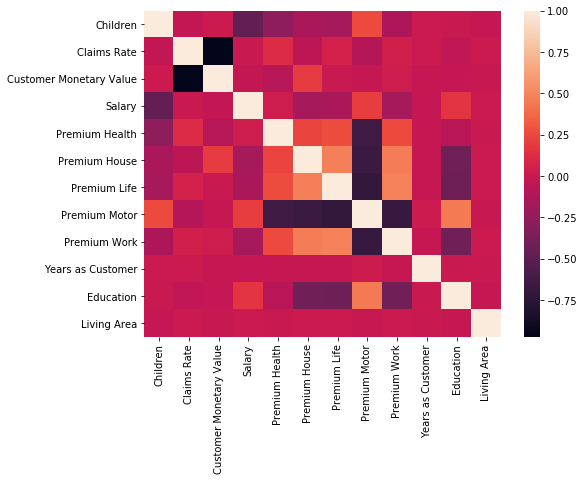

In [23]:
fig, axes = plt.subplots(figsize=(8,6))
correlations = df.corr(method='spearman')
ticks = ["Children", 'Claims Rate', 'Customer Monetary Value', 'Salary', 'Premium Health', 'Premium House',
         'Premium Life', 'Premium Motor', 'Premium Work', 'Years as Customer', 'Education', 'Living Area'];
sns.heatmap(correlations, xticklabels = ticks,
           yticklabels=ticks)
plt.savefig('heatmap.jpeg');

In [15]:
df = premium_proportion()

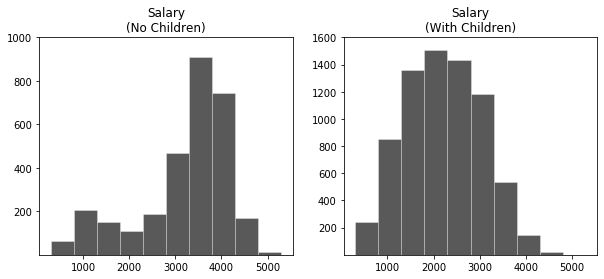

In [16]:
fig = plt.figure(figsize=(10,4))

ax1 =plt.subplot2grid((1,2), (0,0))
x = [i for i in range(300,5500, 500)]
yticks1=[i for i in range(200,1200,200)]
ax1 = df['month_salary'][df['Children']==0.0].hist(bins=x, color='black', edgecolor='white', alpha=0.65, linewidth=0.5)
ax1.set_yticks(yticks1)
ax1.grid(False)
ax1.set_title('Salary\n(No Children)')

ax2 =plt.subplot2grid((1,2), (0,1))
yticks2=[i for i in range(200,1800,200)]
ax2 = df['month_salary'][df['Children']==1.0].hist(bins=x, color='black', edgecolor='white', alpha=0.65, linewidth=0.5)
ax2.set_yticks(yticks2)
ax2.grid(False)
ax2.set_title('Salary\n(With Children)')

plt.savefig('dist_salary.jpeg')

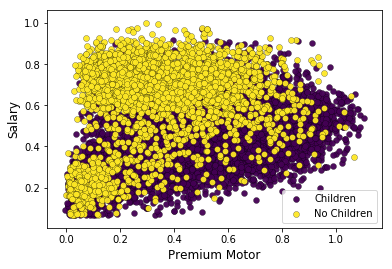

In [17]:
fig = plt.figure(figsize=(6,4))
df['Children'].unique()
cmap = plt.get_cmap("viridis", len(df['Children'].unique()))
ax=plt.subplot2grid((1,1), (0,0))

for i,j in enumerate(df['Children'].unique()):
    ax.scatter((df['premium_motor'][df['Children']==j]), df['month_salary'][df['Children']==j]/df['month_salary'].max(), alpha=0.95,
               color=cmap(i), edgecolor='black', linewidth=0.25, label=('No Children' if j==0 else 'Children'))
    ax.legend()
ax.set_xlabel('Premium Motor', fontsize=12)
ax.set_ylabel('Salary', fontsize=12)

plt.savefig('motor_salary_prop')

### Divide data frame by:
* consume Variables,
* Engagement Variables and 
* Categorical Variables:

In [192]:
engagement, consume, categorical= define_group_variables(df)
df_engagement, df_consume, df_categorical = grouped_data_frames(df)

In [20]:
len(df_engagement.columns) + len(df_consume.columns) + len(df_categorical.columns) == len(df.columns)

True

## PCA

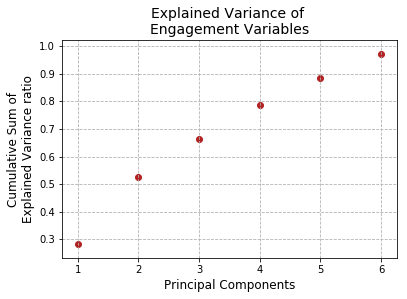

In [26]:
pca_engagement = PCA(0.9)
components_engagement = pca_engagement.fit_transform(standard_scaling(df_engagement))
y1=pca_engagement.explained_variance_ratio_
y3 = y1.cumsum()

fig = plt.figure(figsize=(6,4))
ax = plt.subplot2grid((1,1), (0,0))

plt.scatter([(i+1) for i in range((len(y1)))], y3, color='firebrick')
ax.set_xticks([i for i in range(1,len(y3)+1)])
ax.grid(linestyle = 'dashed')
ax.set_xlabel('Principal Components', fontsize=12)
ax.set_ylabel('Cumulative Sum of\nExplained Variance ratio', fontsize=12)
ax.set_title('Explained Variance of \nEngagement Variables', fontsize=14)
plt.savefig('engagement_pca')

In [27]:
pd.DataFrame(pca_engagement.components_, columns=df_engagement.columns)

,claims_rate,customer_monetary_value,month_salary,years_as_customer,education,sum_premiums,balance,engagement
0,0.192837,-0.226093,0.436400,-0.008617,0.373188,-0.454574,-0.216207,-0.573171
1,0.680829,-0.669366,-0.144776,0.008113,-0.127462,0.120130,0.057546,0.182773
2,0.021440,-0.002833,0.515386,-0.310043,-0.201885,0.299857,0.677472,-0.219413
3,0.003140,0.002551,0.171544,0.950515,-0.046363,0.097773,0.222887,-0.075435
4,-0.000184,0.010714,0.329876,0.013286,-0.745997,0.111704,-0.554889,-0.118320
5,0.037264,0.010902,0.301640,-0.008856,0.492278,0.718280,-0.364899,0.126537


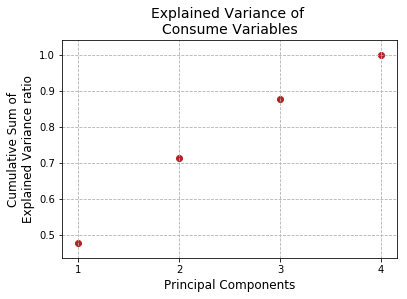

In [28]:
pca_consume = PCA(0.9)
components_consume = pca_consume.fit_transform(standard_scaling(df_consume))
y1=pca_consume.explained_variance_ratio_
y3 = y1.cumsum()

fig = plt.figure(figsize=(6,4))
ax = plt.subplot2grid((1,1), (0,0))

plt.scatter([(i+1) for i in range((len(y1)))], y3, color='firebrick')
ax.set_xticks([i for i in range(1,len(y3)+1)])
ax.grid(linestyle = 'dashed')
ax.set_xlabel('Principal Components', fontsize=12)
ax.set_ylabel('Cumulative Sum of\nExplained Variance ratio', fontsize=12)
ax.set_title('Explained Variance of \nConsume Variables', fontsize=14)
plt.savefig('consume_pca.jpeg')

In [29]:
pd.DataFrame(pca_consume.components_, columns=df_consume.columns)

,premium_house,premium_health,premium_life,premium_work,premium_motor
0,0.475659,0.098251,0.437939,0.432884,-0.620416
1,-0.510923,0.827263,0.167071,0.160401,-0.030857
2,-0.429349,-0.453906,0.484908,0.527889,0.309558
3,0.012839,0.018328,-0.719694,0.693841,-0.011157


### Effect of different scalings in PCA

,claims_rate,customer_monetary_value,month_salary,years_as_customer,education,sum_premiums,balance,engagement
0,0.010129,-0.049626,0.062117,0.008444,0.441977,-0.225072,-0.853337,-0.138997
1,0.033399,-0.018933,-0.115176,0.002396,-0.862343,0.027408,-0.478503,0.109096
2,0.657605,-0.636421,0.227062,0.008529,-0.085359,-0.160981,0.101935,-0.259425
3,0.297955,-0.240965,-0.634244,0.121256,0.214816,0.165149,-0.057376,0.599564
4,0.044556,-0.034058,-0.071447,-0.992512,0.027854,0.023484,-0.015901,0.071346


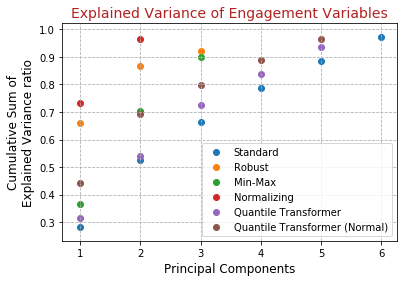

In [40]:
#pca_scaling(df_engagement, 'Engagement')
d=call_scaling_function(df_engagement, scaling_functions_names[2])

pca=PCA(0.9)
pca_components=pca.fit_transform(d)
pd.DataFrame(pca.components_, columns=df_engagement.columns)

In [37]:
#pca_scaling(df_consume, 'Consume')
d=call_scaling_function(df_consume, scaling_functions_names[5])

pca=PCA(0.9)
pca_components=pca.fit_transform(d)
pd.DataFrame(pca.components_, columns=df_consume.columns)

,premium_house,premium_health,premium_life,premium_work,premium_motor
0,-0.468513,-0.135430,-0.450000,-0.445339,0.601106
1,0.504454,-0.827718,-0.180112,-0.160484,-0.047039
2,-0.443010,-0.483702,0.386632,0.588768,0.271370
3,0.059230,0.082235,-0.766108,0.633438,-0.039538


## Elbow Graph for both groups of variables

In [193]:
df_engagement, df_consume, df_categorical = grouped_data_frames(df)

### Get elbow graph for one particular scaling:

In [31]:
scaled_engagement=pd.DataFrame(standard_scaling(df_engagement), index=df_engagement.index.get_values(),
                        columns=df_engagement.columns)
#x, n_clusters=create_kmeans_clusters(scaled_engagement,scaled_engagement)

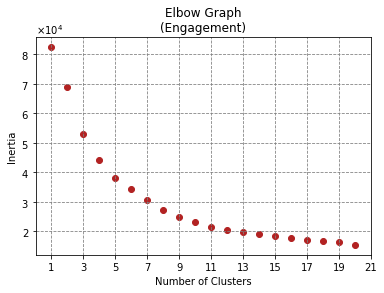

In [293]:
fig=plt.figure(figsize=(6,4))
ax=plt.subplot2grid((1,1),(0,0))
ax.scatter(x,n_clusters, color='firebrick')
ax.grid(color='gray', linestyle='dashed')
ax.set_title('Elbow Graph\n(Engagement)')
ax.set_xlabel('Number of Clusters')
ax.set_ylabel('Inertia')
ax.ticklabel_format(style='sci', axis='y', scilimits=(1,4), useMathText=True, fontsize=12)
xticks=[i for i in range(1,22,2)]
ax.set_xticks(xticks)
plt.savefig('elbow_engagement')

In [32]:
scaled_consume=pd.DataFrame(standard_scaling(df_consume), index=df_consume.index.get_values(),
                        columns=df_consume.columns)
#x, n_clusters=create_kmeans_clusters(scaled_consume,scaled_consume)

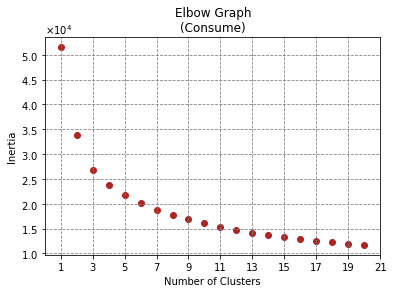

In [44]:
fig=plt.figure(figsize=(6,4))
ax=plt.subplot2grid((1,1),(0,0))
ax.scatter(x,n_clusters, color='firebrick')
ax.grid(color='gray', linestyle='dashed')
ax.set_title('Elbow Graph\n(Consume)')
ax.set_xlabel('Number of Clusters')
ax.set_ylabel('Inertia')
ax.ticklabel_format(style='sci', axis='y', scilimits=(1,4), useMathText=True, fontsize=12)
xticks=[i for i in range(1,22,2)]
ax.set_xticks(xticks)
plt.savefig('elbow_consume')

### Final result:
* 4 clusters for consume variables
* 5 clusters for engagement variables

### Elbow graph for all scaling functions

In [39]:
#elbow_graph_scaling(df_engagement, 'Engagement')
#plt.savefig('elbow_engagement')

In [40]:
#elbow_graph_scaling(df_consume, 'Consume')
#plt.savefig('elbow_consume')

In [197]:
cost

[9168.0, 6120.0, 3952.0, 2891.0, 1623.0, 1163.0, 313.0, 0.0]

## Number of clusters for categorical Variables: K modes

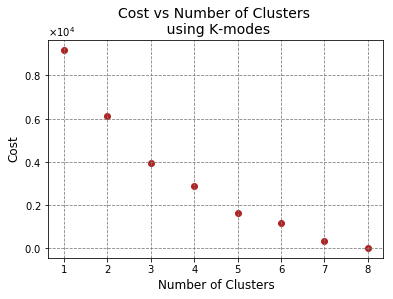

In [198]:
#clusters_categorical, cost, number_clusters = elbow_graph_kmodes(df_categorical.astype(str))
fig = plt.figure()
ax = plt.subplot2grid((1,1),(0,0))

ax.scatter([i for i in range(1,len(cost)+1)], cost, color='firebrick')
ax.set_xlabel('Number of Clusters', fontsize=12)
ax.set_ylabel('Cost', fontsize=12)
ax.set_title('Cost vs Number of Clusters \n using K-modes', fontsize=14)
ax.grid(linestyle='dashed', color='gray')
ax.ticklabel_format(style='sci', axis='y', scilimits=(1,2), useMathText=True, fontsize=12)
plt.savefig('kmodes_elbow')

In [199]:
#Choosing 4 clusters
km = KModes(n_clusters=4, init='Huang', n_init=20, verbose=1)
clusters_kmodes = km.fit(df_categorical.astype(str))     

Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 0, cost: 3365.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 2, iteration: 1/100, moves: 0, cost: 3783.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 3, iteration: 1/100, moves: 3342, cost: 3229.0
Run 3, iteration: 2/100, moves: 1306, cost: 3229.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 4, iteration: 1/100, moves: 0, cost: 2473.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 5, iteration: 1/100, moves: 0, cost: 3910.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 6, iteration: 1/100, moves: 2642, cost: 3647.0
Run 6, iteration: 2/100, moves: 0, cost: 3647.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 7, iteration: 1/100, moves: 587, cost: 4577

In [200]:
clusters_kmodes.cluster_centroids_

array([['4', '0.0'],
       ['1', '1.0'],
       ['4', '1.0'],
       ['3', '1.0']], dtype='<U3')

In [33]:
clusters_kmodes.labels_

array([3, 1, 0, ..., 2, 1, 1], dtype=uint8)

## Add columns with labels from each group:

### Scale data frames with most appropriate scaling method

In [312]:
df_engagement, df_consume, df_categorical=grouped_data_frames(df)
df_engagement = pd.DataFrame(call_scaling_function(df_engagement, scaling_functions[0]), index=df_engagement.index.get_values(),
                             columns=df_engagement.columns)
df_consume = pd.DataFrame(call_scaling_function(df_consume, scaling_functions[0]), index=df_consume.index.get_values(), columns=df_consume.columns)

### Apply k-means to each group of variables and get the final clusters

In [446]:
df_kmeans=pd.concat([df_engagement, df_consume], axis=1)
df_kmeans, kmeans_engagement=columns_clusters(df_kmeans, 5, 10, df_engagement, 'engagement_labels')
df_kmeans, kmeans_consume=columns_clusters(df_kmeans, 4, 10, df_consume, 'consume_labels')

## Search for results including K-modes clusters

In [449]:
df_kmodes=pd.concat([df_engagement, df_kmeans['consume_labels'], pd.DataFrame(clusters_kmodes.labels_, columns=['kmodes'],
                                                 index=df_engagement.index.get_values())], axis=1)
df_kmodes=define_label(df_kmodes,'consume_labels', 'kmodes', 'labels')
labels=df_kmodes['labels'].unique()
print('NUMBER OF CLUSTERS: %d'%len(labels))

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


NUMBER OF CLUSTERS: 16


In [450]:
df_kmodes['labels'].unique()

array([0, 5, 6, 9, 1, 10, 13, 8, 11, 7, 12, 15, 2, 14, 4, 3], dtype=object)

### Too many clusters, right?
## Hierarchical Clustering to Merge Clusters
#### For engagement and categorical variables:
* the first result had most points squeezed at the bottom
    * We discarded observations from the branches with outliers
    * Then we discarded clusters smaller than 100

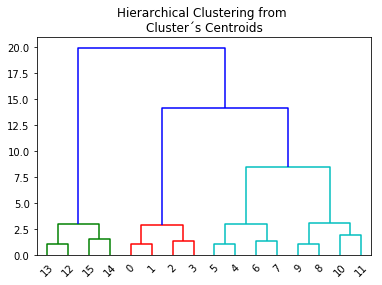

In [451]:
df_hierarchical=hierarchical_clustering_centroids(df_kmodes.drop(['consume_labels', 'kmodes'], axis=1),
                                                 df_kmodes['labels'].unique(), 'labels')
Z = hierarchy.linkage(df_hierarchical, method = 'ward')#method='single, complete
fig=plt.figure(figsize=(6,4))
ax=plt.subplot2grid((1,1),(0,0))
hierarchy.dendrogram(Z,orientation = 'top',leaf_rotation=45.,leaf_font_size=10.,
           show_contracted=True,show_leaf_counts=True,labels=df_hierarchical.index.get_values())
ax.set_title('Hierarchical Clustering from \nCluster´s Centroids')
plt.savefig('report\dendrogram_kmodes')

#### To not lose any information:

In [452]:
df_kmodes_categorical=pd.concat([df_kmodes, df_categorical], axis=1)

In [454]:
size_cluster=print_size_clusters(df_kmodes, df_kmodes['labels'].unique(), 'labels', True)
array_labels=get_array_labels(size_cluster, df_kmodes['labels'].unique(), 100)
array_labels

label|#points
0 1246
5 207
6 280
9 829
1 1199
10 1343
13 643
8 821
11 417
7 81
12 656
15 339
2 488
14 907
4 198
3 642


,0
0,1246
5,207
6,280
9,829
1,1199
10,1343
13,643
8,821
11,417
12,656


In [455]:
df_kmodes['labels'][df_kmodes['labels']==13]=12
df_kmodes['labels'][df_kmodes['labels']==15]=14

df_kmodes['labels'][df_kmodes['labels']==3]=2

df_kmodes['labels'][df_kmodes['labels']==6]=4
df_kmodes['labels'][df_kmodes['labels']==7]=4
df_kmodes['labels'][df_kmodes['labels']==5]=4

df_kmodes['labels'][df_kmodes['labels']==9]=8

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher

In [456]:
len(df_kmodes['labels'].unique())

9

In [457]:
size_cluster=print_size_clusters(df_kmodes, df_kmodes['labels'].unique(), 'labels', False)
array_labels=get_array_labels(size_cluster, df_kmodes['labels'].unique(), 100)
array_labels

label|#points


,0
0,1246
4,766
8,1650
1,1199
10,1343
12,1299
11,417
14,1246
2,1130


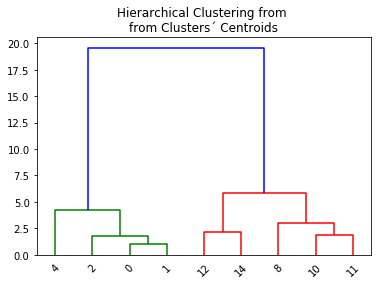

In [458]:
df_hierarchical=hierarchical_clustering_centroids(df_kmodes.drop(['consume_labels', 'kmodes'], axis=1),
                                                  list(array_labels.index.get_values()), 'labels')
plot_dendrogram(df_hierarchical, 'from Clusters´ Centroids', 'dendrogram_kmodes')

In [480]:
df[df_kmodes['labels']==0].describe()

,Children,claims_rate,customer_monetary_value,month_salary,premium_health,premium_house,premium_life,premium_motor,premium_work,years_as_customer,education,living_area,sum_premiums,balance,engagement
count,1246.0,1246.000000,1246.000000,1246.000000,1246.000000,1246.000000,1246.000000,1246.000000,1246.000000,1246.000000,1246.000000,1246.000000,1246.000000,1246.000000,1246.000000
mean,1.0,0.648834,196.936042,2536.783465,0.161973,0.075405,0.018909,0.725160,0.018554,29.945227,15.142857,1.257624,630.968046,0.971343,0.266410
std,0.0,0.569218,345.634911,627.487984,0.063728,0.102962,0.020214,0.132032,0.021326,6.661711,3.480360,0.437502,64.630996,0.054677,0.082640
min,1.0,0.000290,-8719.015858,823.195815,0.021114,-0.153520,-0.012331,0.436679,-0.024581,18.003780,4.000000,1.000000,487.248854,0.737353,0.128359
25%,1.0,0.251093,-24.005978,2108.716987,0.114272,0.006899,0.004921,0.619714,0.004454,24.001292,12.000000,1.000000,583.586580,0.977573,0.209842
50%,1.0,0.779569,124.917607,2525.375923,0.159977,0.077587,0.015635,0.722668,0.016189,29.998805,16.000000,1.000000,627.308839,1.000000,0.248061
75%,1.0,0.999021,432.338436,2940.060173,0.206021,0.142142,0.027812,0.815871,0.029130,35.996318,16.000000,2.000000,670.217869,1.000000,0.301386
max,1.0,15.650051,698.273409,4585.961704,0.354863,0.359609,0.148211,1.103320,0.116801,42.000435,21.000000,2.000000,841.260575,1.000000,0.817915


In [463]:
df_kmeans=define_label(df_kmeans,'engagement_labels', 'consume_labels', 'labels')
labels=df_kmeans['labels'].unique()
print('NUMBER OF CLUSTERS: %d'%len(labels))

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


NUMBER OF CLUSTERS: 18


### Clusters' coordinates

In [133]:
size_engagement=print_size_clusters(df_kmeans, df_kmeans['engagement_labels'].unique(), 'engagement_labels')

label|#points
1 4097
4 1272
0 4285
3 637
2 5


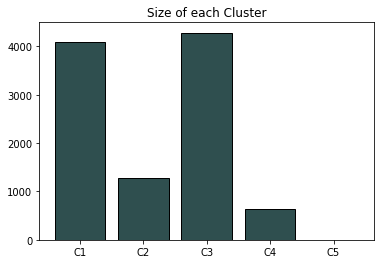

In [135]:
plot_size_clusters(size_engagement, 'report\size_engagement_clusters', [i for i in range(0,5000, 1000)])

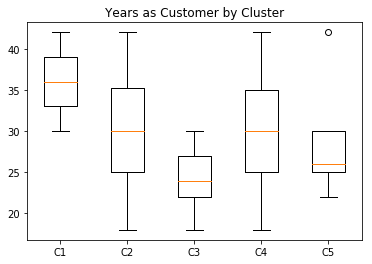

In [136]:
#considering only engagement clusters
years_customer_plot(df_kmeans, df, 'engagement_labels', list(df_kmeans['engagement_labels'].unique()))

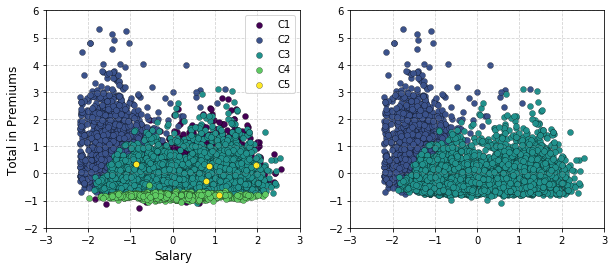

In [137]:
plot_clusters(df_kmeans, df_kmeans['engagement_labels'].unique(), 'engagement_labels', 'month_salary', 'sum_premiums', 
              1,2, 'Salary', 'Total in Premiums', 'report\salary_sum_engagement',
              (-3,3), (-2,6), (-3,3), (-2,6))

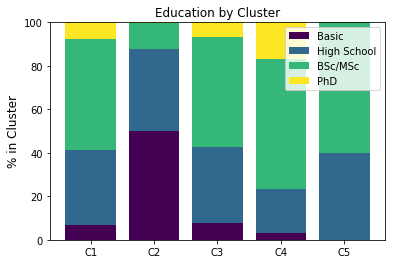

In [138]:
plot_education(df, df_kmeans, df_kmeans['engagement_labels'].unique(), 'engagement_labels')

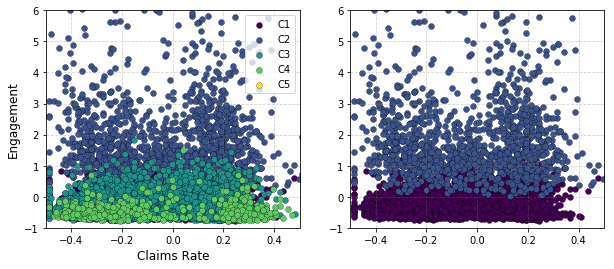

In [152]:
plot_clusters(df_kmeans, df_kmeans['engagement_labels'].unique(), 'engagement_labels', 'claims_rate', 'engagement', 
              1,0, 'Claims Rate', 'Engagement', 'report\engage_salary_engagement',
              (-0.5,0.5), (-1,6), (-0.5,0.5), (-1,6))

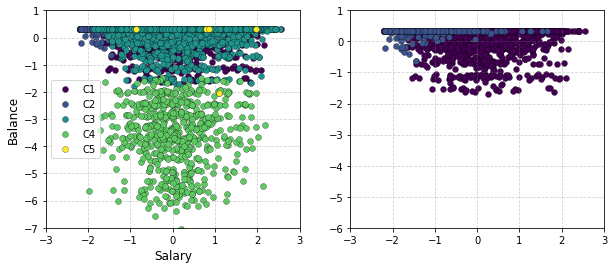

In [158]:
plot_clusters(df_kmeans, df_kmeans['engagement_labels'].unique(), 'engagement_labels', 'month_salary', 'balance', 
              0,1, 'Salary', 'Balance', 'report\salary_balance_engagement',
              (-3,3), (-7,1), (-3,3), (-6,1))

In [141]:
#labels of each cluster
for i,j in enumerate(df_kmeans['engagement_labels'].unique()):
    print('C%d: %d'%(i+1,j))

C1: 1
C2: 4
C3: 0
C4: 3
C5: 2


In [140]:
pd.DataFrame(kmeans_engagement, columns=df_engagement.columns)

,claims_rate,customer_monetary_value,month_salary,years_as_customer,education,sum_premiums,balance,engagement
0,-0.018608,0.008638,0.256790,-0.857724,0.116459,-0.119329,0.228304,-0.280668
1,-0.019040,0.006301,0.161264,0.882898,0.159560,-0.141715,0.218434,-0.256576
2,39.618083,-39.924328,0.767352,-0.147226,0.210047,-0.027479,-0.152480,-0.374069
3,-0.009061,-0.055073,0.078669,0.065097,0.498722,-0.832197,-3.566672,-0.462919
4,-0.027181,0.135127,-1.426657,0.009561,-1.156926,1.275352,0.314113,2.005137


## K-means results: Consume

In [46]:
df_kmeans=define_label(df_kmeans.drop('labels', axis=1),'engagement_labels', 'consume_labels', 'labels')
labels=df_kmeans['labels'].unique()
print('NUMBER OF CLUSTERS: %d'%len(labels))

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


NUMBER OF CLUSTERS: 18


In [47]:
size_consume=print_size_clusters(df_kmeans, df_kmeans['consume_labels'].unique(), 'consume_labels')

label|#points
1 3575
2 767
3 3411
0 2543


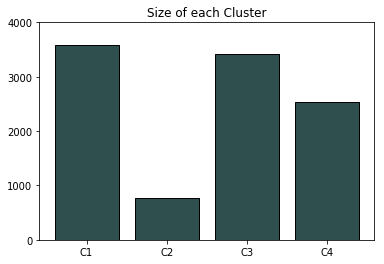

In [166]:
plot_size_clusters(size_consume, 'size_consume', [i for i in range(0,5000, 1000)])

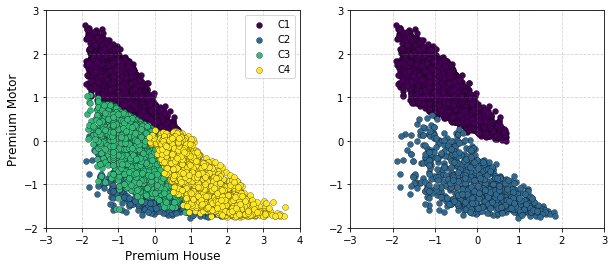

In [178]:
plot_clusters(df_kmeans, df_kmeans['consume_labels'].unique(), 'consume_labels', 'premium_house', 'premium_motor', 
              0,1, 'Premium House', 'Premium Motor', 'report\house_motor_consume',
              (-3,4), (-2,3), (-3,3), (-2,3))

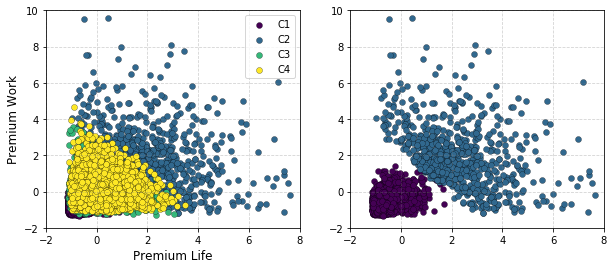

In [180]:
plot_clusters(df_kmeans, df_kmeans['consume_labels'].unique(), 'consume_labels', 'premium_life', 'premium_work', 
              1,0, 'Premium Life', 'Premium Work', 'report\life_work_consume',
              (-2,8), (-2,10), (-2,8), (-2,10))

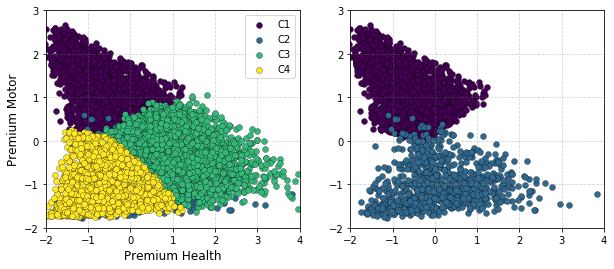

In [183]:
plot_clusters(df_kmeans, df_kmeans['consume_labels'].unique(), 'consume_labels', 'premium_health', 'premium_motor', 
              0,1, 'Premium Health', 'Premium Motor', 'report\health_motor_consume',
              (-2,4), (-2,3), (-2,4), (-2,3))

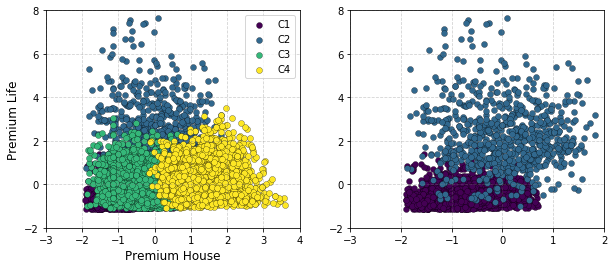

In [175]:
plot_clusters(df_kmeans, df_kmeans['consume_labels'].unique(), 'consume_labels', 'premium_house', 'premium_life', 
              0,1, 'Premium House', 'Premium Life', 'report\life_house_engagement',
              (-3,4), (-2,8), (-3,2), (-2,8))

In [167]:
#labels of each cluster
for i,j in enumerate(df_kmeans['consume_labels'].unique()):
    print('C%d: %d'%(i+1,j))

C1: 0
C2: 1
C3: 2
C4: 3


In [168]:
pd.DataFrame(kmeans_consume, columns=df_consume.columns)

,premium_house,premium_health,premium_life,premium_work,premium_motor
0,-0.724234,-0.613602,-0.581532,-0.574597,1.109327
1,-0.001476,0.091099,2.230398,1.977940,-0.999615
2,-0.246986,1.009449,-0.063748,-0.040768,-0.222155
3,1.349974,-0.519228,0.231222,0.266686,-0.960341


## Final Clusters

In [214]:
size_clusters=print_size_clusters(df_kmeans, df_kmeans['labels'].unique(), 'labels')

label|#points
0 1521
5 247
9 263
10 1597
2 1584
8 1541
11 884
12 499
7 901
3 765
14 108
13 30
6 111
1 227
16 1
18 3
19 1
4 13


In [215]:
array_labels=pd.DataFrame(size_clusters, index=df_kmeans['labels'].unique())
for i,j in enumerate(array_labels.iloc[:,-1]):
    if j<100:
        array_labels=array_labels[array_labels.iloc[:,-1]!=j]
array_labels      

,0
0,1521
5,247
9,263
10,1597
2,1584
8,1541
11,884
12,499
7,901
3,765


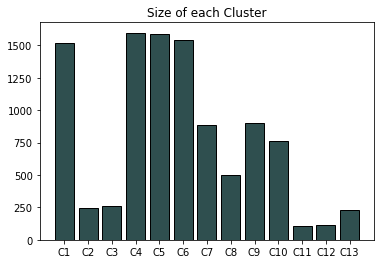

In [216]:
plot_size_clusters(array_labels.iloc[:,-1], 'report\size_clusters', [i for i in range(0,1600,250)])

## Let's see how the clusters blend in together

In [217]:
df_columns=df_kmeans.drop(['engagement_labels', 'consume_labels', 'labels'], axis=1)
df_hierarchical=pd.DataFrame(columns=df_columns.columns, index=array_labels.index.get_values())
for i in array_labels.index.get_values():
    for j in df_columns:
        df_hierarchical.loc[i,j]=df_kmeans[j][df_kmeans['labels']==i].mean()

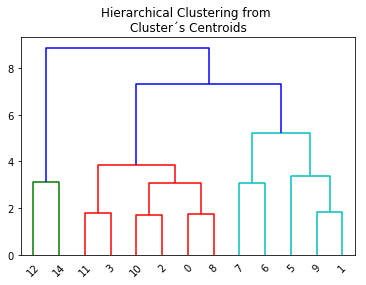

In [219]:
Z = hierarchy.linkage(df_hierarchical, method = 'ward')#method='single, complete
fig=plt.figure(figsize=(6,4))
ax=plt.subplot2grid((1,1),(0,0))
hierarchy.dendrogram(Z,orientation = 'top',leaf_rotation=45.,leaf_font_size=10.,
           show_contracted=True,show_leaf_counts=True,labels=df_hierarchical.index.get_values())
ax.set_title('Hierarchical Clustering from \nCluster´s Centroids')
plt.savefig('report\dendrogram')

### Smaller than 100? Merge it.

In [220]:
df_kmeans['labels'][df_kmeans['labels']==14]=12
df_kmeans['labels'][df_kmeans['labels']==11]=3
df_kmeans['labels'][df_kmeans['labels']==7]=6
df_kmeans['labels'][df_kmeans['labels']==9]=1
df_kmeans['labels'][df_kmeans['labels']==5]=1

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\ProgramData\Anac

In [223]:
size_clusters=print_size_clusters(df_kmeans, df_kmeans['labels'].unique(), 'labels')

label|#points
0 1521
1 737
10 1597
2 1584
8 1541
3 1649
12 607
6 1012
13 30
16 1
18 3
19 1
4 13


In [224]:
array_labels=pd.DataFrame(size_clusters, index=df_kmeans['labels'].unique())
outliers=[]
for i,j in enumerate(array_labels.iloc[:,-1]):
    if j<100:
        outliers.append(labels[i])
        array_labels=array_labels[array_labels.iloc[:,-1]!=j]       
array_labels      

,0
0,1521
1,737
10,1597
2,1584
8,1541
3,1649
12,607
6,1012


In [243]:
size_clusters=print_size_clusters(df_kmeans, list(array_labels.index.get_values()), 'labels')

label|#points
0 1521
1 737
10 1597
2 1584
8 1541
3 1649
12 607
6 1012


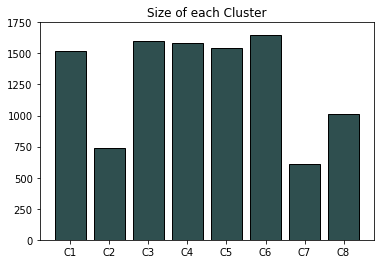

In [246]:
plot_size_clusters(array_labels.iloc[:,-1], 'report\size_clusters', [i for i in range(0,2000,250)])

In [72]:
df_kmeans['cluster_label']=0
for i,j in enumerate(labels):
    df_kmeans['cluster_label'][df_kmeans['labels']==j]=i+1
#df_kmeans=df_kmeans.drop('cluster', axis=1)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [73]:
df_kmeans['cluster_label'].unique()

array([14,  5, 10, 18,  2, 13,  9,  6,  3,  4,  7,  8, 12, 11],
      dtype=int64)

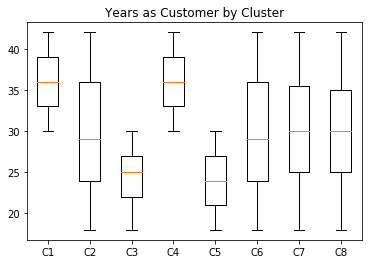

In [236]:
#years_customer_plot(df_kmeans, df, 'labels', list(array_labels.index.get_values()))
years_customer_plot(df_kmeans, df, 'labels', list(array_labels.index.get_values()))
#df_kmeans['cluster'].unique()

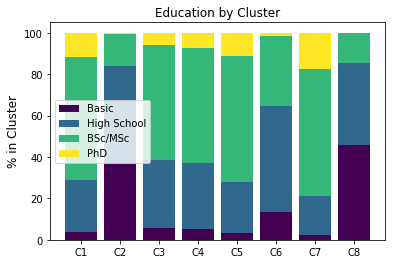

In [269]:
plot_education(df, df_kmeans, list(array_labels.index.get_values()), 'labels')

In [552]:
df_kmeans[df_kmeans['labels']==0].describe()
#imported_df[df_kmeans['labels']==6].describe()
df[df_kmeans['labels']==0].describe()

,Children,claims_rate,customer_monetary_value,month_salary,premium_health,premium_house,premium_life,premium_motor,premium_work,years_as_customer,education,living_area,sum_premiums,balance,engagement
count,1521.000000,1521.000000,1521.000000,1521.000000,1521.000000,1521.000000,1521.000000,1521.000000,1521.000000,1521.000000,1521.000000,1521.000000,1521.000000,1521.000000,1521.000000
mean,0.873767,0.647665,204.749153,2611.525372,0.163238,0.107898,0.019842,0.689795,0.019227,35.715004,15.108481,2.727811,649.885605,0.992824,0.269066
std,0.332221,0.730884,448.806267,700.429856,0.061602,0.085819,0.020785,0.114525,0.021582,3.367471,3.421978,1.249030,57.477386,0.014170,0.085342
min,0.000000,0.000290,-14714.253891,862.689553,0.024495,-0.037156,-0.012570,0.436679,-0.019086,29.998805,4.000000,1.000000,538.298592,0.928452,0.128439
25%,1.000000,0.260050,-20.814758,2102.792927,0.117405,0.041568,0.006004,0.602471,0.004396,32.997561,12.000000,1.000000,606.647031,0.992924,0.209509
50%,1.000000,0.779569,128.108827,2584.616530,0.162444,0.099241,0.015760,0.685498,0.016329,35.996318,16.000000,3.000000,641.190326,1.000000,0.251582
75%,1.000000,0.988571,442.975835,3068.414821,0.206687,0.158891,0.029458,0.777907,0.029443,38.995074,16.000000,4.000000,683.875934,1.000000,0.307408
max,1.000000,25.361173,674.871132,4882.164739,0.333645,0.359609,0.148211,0.981082,0.116983,42.000435,21.000000,4.000000,857.324496,1.000000,0.850462


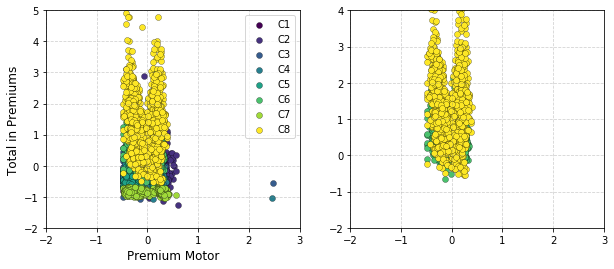

In [478]:
plot_clusters(df_kmeans, list(array_labels.index.get_values()), 'labels', 'claims_rate',
              'sum_premiums', 5,7, 'Premium Motor', 'Total in Premiums', 'report\motor_sum2',
              (-2,3), (-2,5), (-2,3), (-2,4))

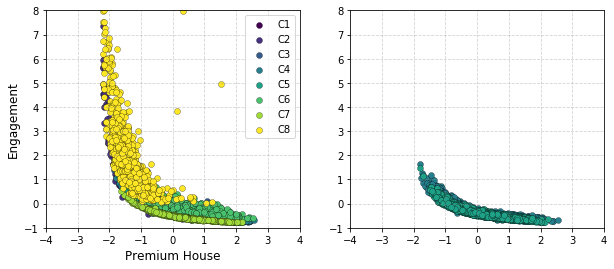

In [473]:
plot_clusters(df_kmeans, list(array_labels.index.get_values()), 'labels', 'month_salary',
              'engagement', 3,4, 'Premium House', 'Engagement', 'report\house_engagement',
              (-4,4), (-1,8), (-4,4), (-1,8))

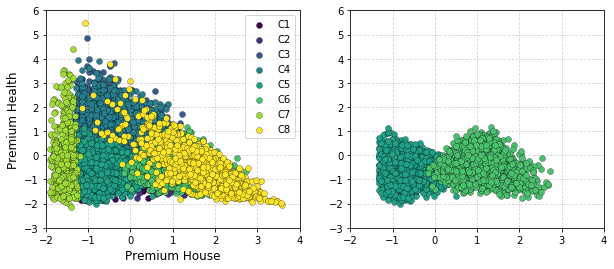

In [443]:
plot_clusters(df_kmeans, array_labels.index.get_values(), 'labels', 'premium_house',
              'premium_health', 5,4, 'Premium House', 'Premium Health', 'report\health_house',
              (-2,4), (-3,6), (-2,4), (-3,6))

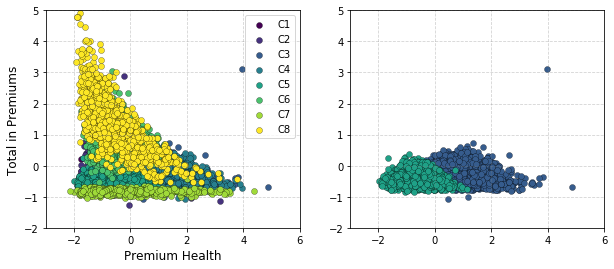

In [315]:
plot_clusters(df_kmeans, array_labels.index.get_values(), 'labels', 'premium_health',
              'sum_premiums', 2,4, 'Premium Health', 'Total in Premiums', 'report\health_sum',
              (-3,6), (-2,5), (-3,6), (-2,5))

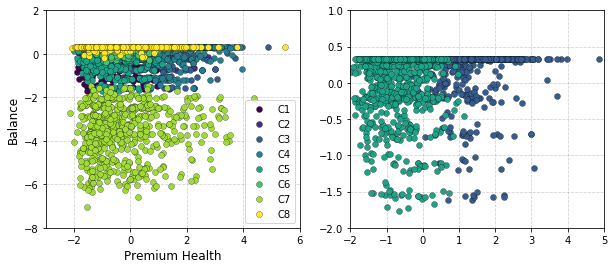

In [384]:
plot_clusters(df_kmeans, array_labels.index.get_values(), 'labels', 'premium_health',
              'balance', 2,4, 'Premium Health', 'Balance', 'report\health_balance',
              (-3,6), (-8,2), (-2,5), (-2,1))

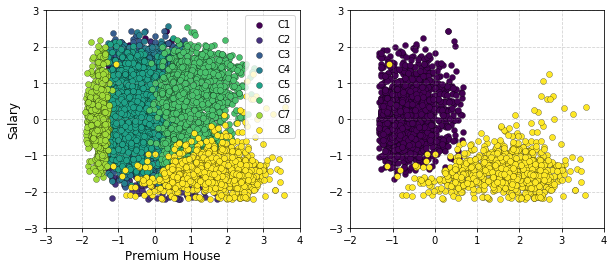

In [418]:
plot_clusters(df_kmeans, array_labels.index.get_values(), 'labels', 'premium_house',
              'month_salary', 0,7, 'Premium House', 'Salary', 'report\house_salary',
              (-3,4), (-3,3), (-2,4), (-3,3))

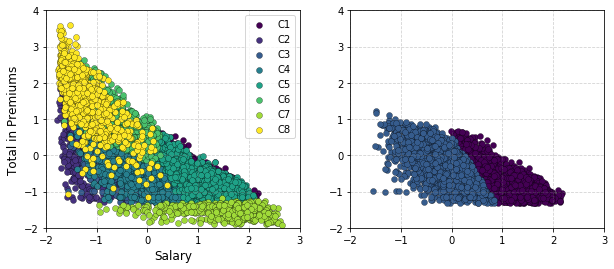

In [391]:
plot_clusters(df_kmeans, array_labels.index.get_values(), 'labels', 'premium_motor',
              'premium_house', 0,2, 'Salary', 'Total in Premiums', 'salary_sum_engagement',
              (-2,3), (-2,4), (-2,3), (-2,4))

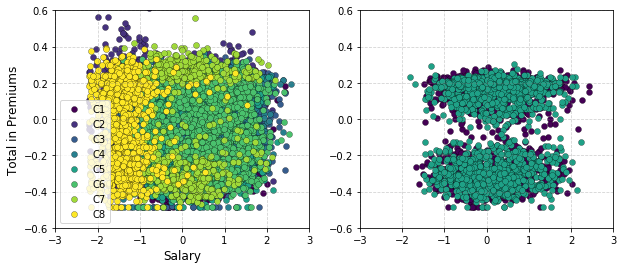

In [444]:
plot_clusters(df_kmeans, array_labels.index.get_values(), 'labels', 'month_salary',
              'claims_rate', 0,4, 'Salary', 'Total in Premiums', 'salary_sum_engagement',
              (-3,3), (-0.6,0.6), (-3,3), (-0.6,0.6))

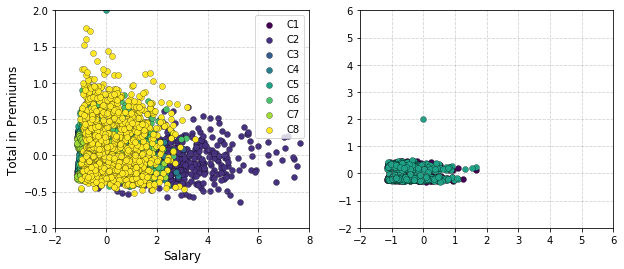

In [445]:
plot_clusters(df_kmeans, array_labels.index.get_values(), 'labels', 'premium_life',
              'customer_monetary_value', 0,4, 'Salary', 'Total in Premiums', 'salary_sum_engagement',
              (-2,8), (-1,2), (-2,6), (-2,6))

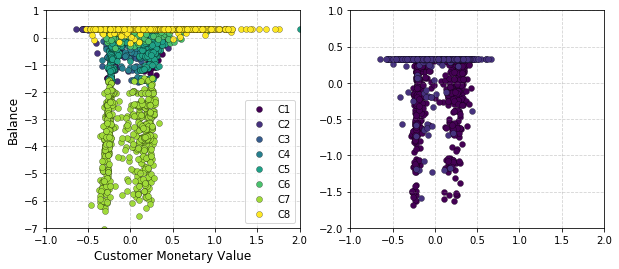

In [428]:
plot_clusters(df_kmeans, array_labels.index.get_values(), 'labels', 'customer_monetary_value',
              'balance', 0,1, 'Customer Monetary Value', 'Balance', 'report\cmv_balance',
              (-1,2), (-7,1), (-1,2), (-2,1))

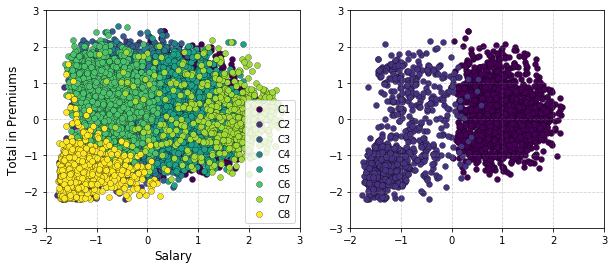

In [398]:
plot_clusters(df_kmeans, array_labels.index.get_values(), 'labels', 'premium_motor',
              'month_salary', 0,1, 'Salary', 'Total in Premiums', 'salary_sum_engagement',
              (-2,3), (-3,3), (-2,3), (-3,3))

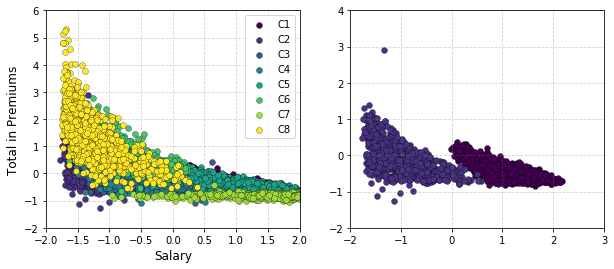

In [399]:
plot_clusters(df_kmeans, array_labels.index.get_values(), 'labels', 'premium_motor',
              'sum_premiums', 0,1, 'Salary', 'Total in Premiums', 'salary_sum_engagement',
              (-2,2), (-2,6), (-2,3), (-2,4))

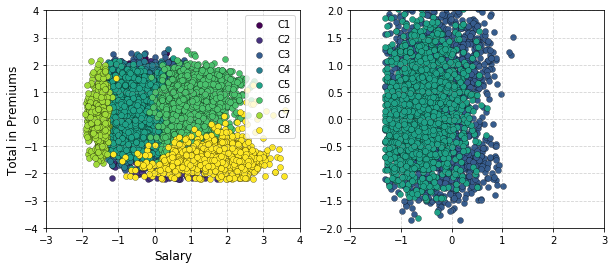

In [400]:
plot_clusters(df_kmeans, array_labels.index.get_values(), 'labels', 'premium_house',
              'month_salary', 4,2, 'Salary', 'Total in Premiums', 'salary_sum_engagement',
              (-3,4), (-4,4), (-2,3), (-2,2))

### bar plot of children variable against all clusters

In [691]:
df_kmeans[df_kmeans['labels']==14].describe()

,claims_rate,customer_monetary_value,month_salary,years_as_customer,education,sum_premiums,balance,engagement,premium_house,premium_health,premium_life,premium_work,premium_motor,engagement_labels,consume_labels,Children
count,108.000000,108.000000,108.000000,108.000000,108.000000,108.000000,108.000000,108.000000,108.000000,108.000000,108.000000,108.000000,108.000000,108.0,108.0,108.000000
mean,0.064201,-0.109627,0.158846,0.042991,0.273933,-0.823348,-3.355248,-0.451824,-1.522364,1.850501,0.123451,0.229217,0.319798,4.0,3.0,0.648148
std,0.200074,0.150326,0.945087,0.940385,0.826570,0.075223,1.116700,0.267579,0.137617,0.873641,0.770023,0.927846,0.470548,0.0,0.0,0.479774
min,-0.263287,-0.466674,-1.639940,-1.811450,-2.197929,-1.011150,-6.175306,-0.760963,-1.878015,0.298389,-0.986375,-1.044271,-0.957705,4.0,3.0,0.000000
25%,-0.108695,-0.244656,-0.586236,-0.751944,-0.345640,-0.863198,-3.977608,-0.663711,-1.588226,1.187694,-0.521107,-0.442504,-0.008813,4.0,3.0,0.000000
50%,0.044884,-0.098744,-0.098386,0.154633,0.580504,-0.822583,-3.242188,-0.502482,-1.504361,1.787401,0.040737,0.097007,0.429136,4.0,3.0,1.000000
75%,0.240278,0.027512,0.998961,0.760351,0.580504,-0.774416,-2.477561,-0.324267,-1.417179,2.386040,0.598663,0.578152,0.702979,4.0,3.0,1.000000
max,0.557826,0.146207,2.018052,1.819857,1.738185,-0.419019,-1.585196,0.534276,-1.321488,4.385086,2.337120,3.539077,1.046852,4.0,3.0,1.000000


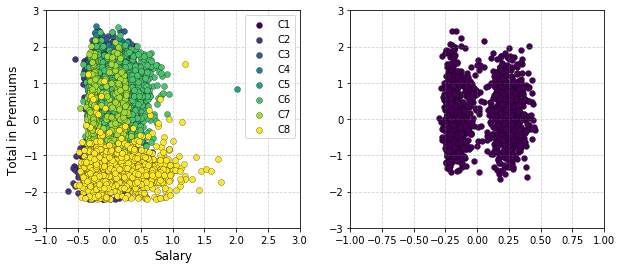

In [405]:
plot_clusters(df_kmeans, array_labels.index.get_values(), 'labels', 'customer_monetary_value',
              'month_salary', 0,0, 'Salary', 'Total in Premiums', 'salary_sum_engagement',
              (-1,3), (-3,3), (-1,1), (-3,3))

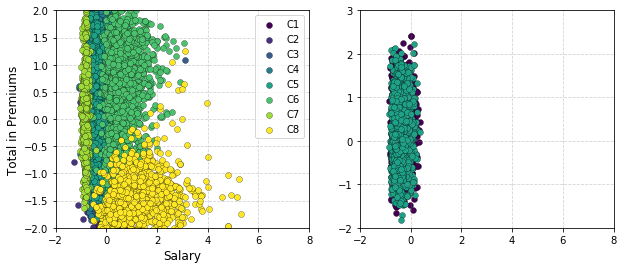

In [872]:
plot_clusters(df_kmeans, array_labels.index.get_values(), 'cluster', 'sum_premiums',
              'month_salary', 4,0, 'Salary', 'Total in Premiums', 'salary_sum_engagement',
              (-2,8), (-2,2), (-2,8), (-2,3))

In [472]:
no_children=[]
with_children=[]
k=10
for i,j in enumerate(array_labels.index.get_values()):
    if (i+1)<k:
        mask_labels=df_kmodes['labels']==j
        mask_children=imported_df['Children']==1.0
        no_children.append((mask_labels&~mask_children).sum())
        with_children.append((mask_labels&mask_children).sum())
no_children=pd.DataFrame(no_children, columns=['nc'])
with_children=pd.DataFrame(with_children, columns=['wc'])
total=[i+j for i,j in zip(with_children['wc'], no_children['nc'])]

In [473]:
no_children1 = [(i/j*100 if j>0 else 0) for i,j in zip(no_children['nc'], total)]
with_children1=[(i/j*100 if j>0 else 0) for i,j in zip(with_children['wc'], total)]

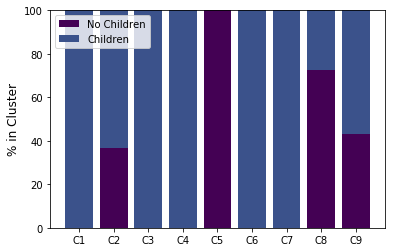

In [474]:
cmap = plt.get_cmap("viridis", len(array_labels))
x = [i for i in range(1,k)]
fig=plt.figure(figsize=(6,4))
ax=plt.subplot2grid((1,1),(0,0))
ax.bar(x, no_children1, label='No Children', color=cmap(0))
ax.bar(x, with_children1, bottom=no_children1, label='Children', color=cmap(2))
xticks=[i for i in range(1,k)]
ax.set_xticks(xticks)
ax.set_xticklabels(['C%d'%i for i in range(1,k)])
ax.set_ylabel('% in Cluster', fontsize=12)
ax.legend(loc=2)
plt.savefig('report\children_kmeans')

In [538]:
#df_consume[df_kmodes['labels']==1].describe()
#df[df_kmodes['labels']==0].describe()
#imported_df[df_kmodes['labels']==0].describe()
df_kmodes[df_kmodes['labels']==2].describe()

,claims_rate,customer_monetary_value,month_salary,years_as_customer,education,sum_premiums,balance,engagement,consume_labels,kmodes
count,1130.000000,1130.000000,1130.000000,1130.000000,1130.000000,1130.000000,1130.000000,1130.000000,1130.0,1130.000000
mean,0.007749,-0.036157,0.339786,0.014819,0.465351,-0.377289,-0.269904,-0.406994,2.0,1.704425
std,1.944903,1.861033,0.790857,1.010850,0.782845,1.480101,1.279832,0.372316,0.0,1.486663
min,-0.487319,-61.679191,-1.790434,-1.811450,-2.197929,-0.983863,-6.257941,-0.777266,2.0,0.000000
25%,-0.303836,-0.206603,-0.230068,-0.903873,0.580504,-0.636124,-0.188784,-0.578380,2.0,0.000000
50%,0.034747,-0.051366,0.306942,0.003704,0.580504,-0.465163,0.322472,-0.469967,2.0,3.000000
75%,0.190859,0.223573,0.900890,0.911281,0.580504,-0.294530,0.322472,-0.331609,2.0,3.000000
max,64.702992,5.119819,2.420371,1.819857,1.738185,38.956589,0.322472,6.143623,2.0,3.000000


In [481]:
array_labels

,0
0,1246
4,766
8,1650
1,1199
10,1343
12,1299
11,417
14,1246
2,1130


## Bar plot for education regarding each cluster

### % in each living area for each cluster

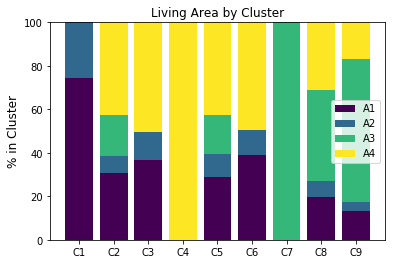

In [478]:
A1=[]
A2=[]
A3=[]
A4=[]
area=df['living_area'].unique()
cmap = plt.get_cmap("viridis", len(area))
for i,j in enumerate(array_labels.index.get_values()):
    for k,l in enumerate(area):
        if (i+1)<10:
            mask_labels=df_kmodes['labels']==j
            mask_area=df['living_area'][mask_labels]==l
            if l==area[0]:
                A1.append((mask_labels&mask_area).sum())
            elif l==area[3]:
                A2.append((mask_labels&mask_area).sum())
            elif l==area[2]:
                A3.append((mask_labels&mask_area).sum())
            else:
                A4.append((mask_labels&mask_area).sum())
A1=pd.DataFrame(A1, columns=['o'])
A2=pd.DataFrame(A2, columns=['t'])
A3=pd.DataFrame(A3, columns=['th'])
A4=pd.DataFrame(A4, columns=['f'])
total=pd.DataFrame(columns=['total'])
total=A1['o']+A2['t']+A3['th']+A4['f']

a1 = [i/j*100 for i,j in zip(A1['o'], total)]
a2=[i/j*100 for i,j in zip(A2['t'], total)]
a3 = [i/j*100 for i,j in zip(A3['th'], total)]
a4=[i/j*100 for i,j in zip(A4['f'], total)]

x = [i for i in range(1,10)]
fig=plt.figure(figsize=(6,4))
ax=plt.subplot2grid((1,1),(0,0))
ax.bar(x, a1, label='A1', color=cmap(0))
ax.bar(x, a2, bottom=a1, label='A2', color=cmap(1))
ax.bar(x, a3, bottom=[i+j for i,j in zip(a1, a2)], label='A3', color=cmap(2))
ax.bar(x, a4, bottom=[i+j+k for i,j,k in zip(a1, a2, a3)], label='A4', color=cmap(3))
xticks=[i for i in range(1,10)]
ax.set_xticks(xticks)
ax.set_xticklabels(['C%d'%(i) for i in range(1,10)])
ax.set_ylabel('% in Cluster', fontsize=12)
ax.set_title('Living Area by Cluster')
ax.legend()
plt.savefig('report\living_area')

## testing with no outliers from claims rate

In [23]:
df2=df[df['claims_rate']<10].copy()
df_engagement, df_consume, df_categorical=grouped_data_frames(df2)

df_engagement = pd.DataFrame(call_scaling_function(df_engagement, scaling_functions[0]), index=df_engagement.index.get_values(),
                             columns=df_engagement.columns)
df_consume = pd.DataFrame(call_scaling_function(df_consume, scaling_functions[0]), index=df_consume.index.get_values(), columns=df_consume.columns)

In [24]:
x, n_clusters=create_kmeans_clusters(df_engagement,df_engagement)

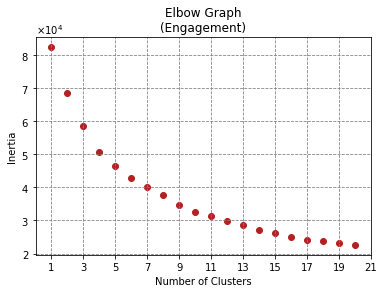

In [25]:
fig=plt.figure(figsize=(6,4))
ax=plt.subplot2grid((1,1),(0,0))
ax.scatter(x,n_clusters, color='firebrick')
ax.grid(color='gray', linestyle='dashed')
ax.set_title('Elbow Graph\n(Engagement)')
ax.set_xlabel('Number of Clusters')
ax.set_ylabel('Inertia')
ax.ticklabel_format(style='sci', axis='y', scilimits=(1,4), useMathText=True, fontsize=12)
xticks=[i for i in range(1,22,2)]
ax.set_xticks(xticks)
plt.savefig('elbow_engagement_nooutliers')

In [125]:
x, n_clusters=create_kmeans_clusters(df_consume,df_consume)

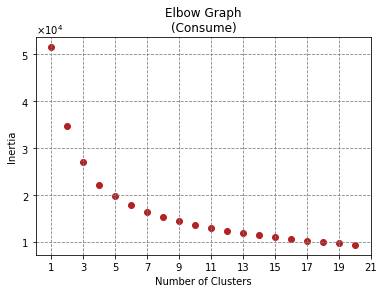

In [127]:
fig=plt.figure(figsize=(6,4))
ax=plt.subplot2grid((1,1),(0,0))
ax.scatter(x,n_clusters, color='firebrick')
ax.grid(color='gray', linestyle='dashed')
ax.set_title('Elbow Graph\n(Consume)')
ax.set_xlabel('Number of Clusters')
ax.set_ylabel('Inertia')
ax.ticklabel_format(style='sci', axis='y', scilimits=(1,4), useMathText=True, fontsize=12)
xticks=[i for i in range(1,22,2)]
ax.set_xticks(xticks)
plt.savefig('elbow_consume_nooutliers')

In [83]:
df_kmeans=pd.concat([df_engagement, df_consume], axis=1)
df_kmeans, kmeans_engagement=columns_clusters(df_kmeans, 5, 10, df_engagement, 'engagement_labels')
df_kmeans, kmeans_consume=columns_clusters(df_kmeans, 4, 10, df_consume, 'consume_labels')

In [84]:
df_kmeans=define_label(df_kmeans,'engagement_labels', 'consume_labels', 'labels')
labels=df_kmeans['labels'].unique()
print('NUMBER OF CLUSTERS: %d'%len(labels))

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


NUMBER OF CLUSTERS: 19


In [85]:
size_engagement=print_size_clusters(df_kmeans, df_kmeans['engagement_labels'].unique(), 'engagement_labels')

label|#points
2 3252
3 2536
1 3165
0 609
4 724


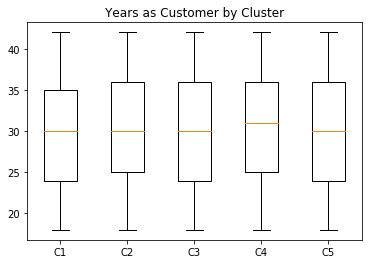

In [86]:
#considering only engagement clusters
years_customer_plot(df_kmeans, df2, 'engagement_labels', list(df_kmeans['engagement_labels'].unique()))

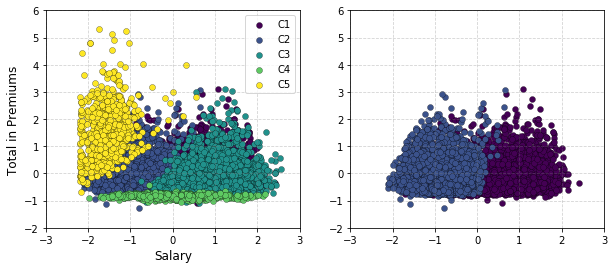

In [88]:
plot_clusters(df_kmeans, df_kmeans['engagement_labels'].unique(), 'engagement_labels', 'month_salary', 'sum_premiums', 
              1,0, 'Salary', 'Total in Premiums', 'report\salary_sum_engagement',
              (-3,3), (-2,6), (-3,3), (-2,6))

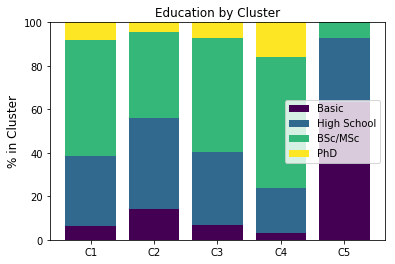

In [89]:
plot_education(df2, df_kmeans, df_kmeans['engagement_labels'].unique(), 'engagement_labels')

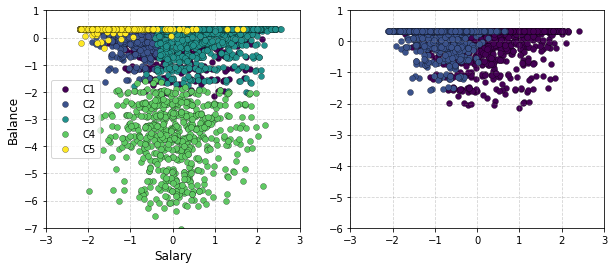

In [90]:
plot_clusters(df_kmeans, df_kmeans['engagement_labels'].unique(), 'engagement_labels', 'month_salary', 'balance', 
              0,1, 'Salary', 'Balance', 'report\salary_balance_engagement',
              (-3,3), (-7,1), (-3,3), (-6,1))

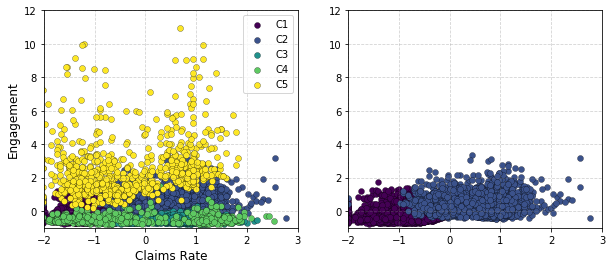

In [91]:
plot_clusters(df_kmeans, df_kmeans['engagement_labels'].unique(), 'engagement_labels', 'claims_rate', 'engagement', 
              0,1, 'Claims Rate', 'Engagement', 'report\engage_salary_engagement',
              (-2,3), (-1,12), (-2,3), (-1,12))

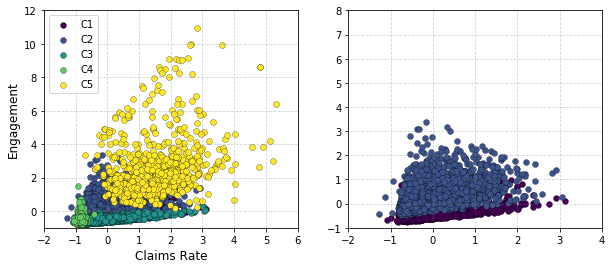

In [104]:
plot_clusters(df_kmeans, df_kmeans['engagement_labels'].unique(), 'engagement_labels', 'sum_premiums', 'engagement', 
              0,1, 'Claims Rate', 'Engagement', 'report\engage_salary_engagement',
              (-2,6), (-1,12), (-2,4), (-1,8))

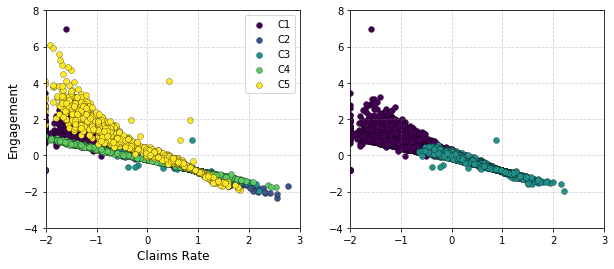

In [111]:
plot_clusters(df_kmeans, df_kmeans['engagement_labels'].unique(), 'engagement_labels', 'claims_rate', 'customer_monetary_value', 
              0,2, 'Claims Rate', 'Engagement', 'report\engage_salary_engagement',
              (-2,3), (-4,8), (-2,3), (-4,8))

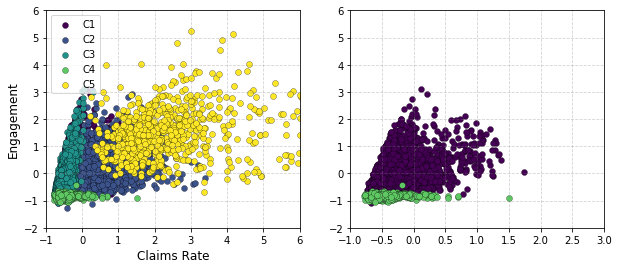

In [124]:
plot_clusters(df_kmeans, df_kmeans['engagement_labels'].unique(), 'engagement_labels', 'engagement', 'sum_premiums', 
              0,3, 'Claims Rate', 'Engagement', 'report\engage_salary_engagement',
              (-1,6), (-2,6), (-1,3), (-2,6))

In [75]:
pd.DataFrame(kmeans_engagement, columns=df_engagement.columns)

,claims_rate,customer_monetary_value,month_salary,years_as_customer,education,sum_premiums,balance,engagement
0,-0.116129,0.517898,-1.448841,0.038383,-1.203701,1.357986,0.314028,2.126257
1,0.735334,-0.641371,0.151360,0.009836,0.084520,-0.145275,0.220152,-0.237727
2,-0.897482,0.691056,0.240258,-0.036076,0.181992,-0.096939,0.215773,-0.275090
3,0.085055,-0.291453,0.068776,0.075351,0.487371,-0.835923,-3.648545,-0.461837


In [128]:
size_consume=print_size_clusters(df_kmeans, df_kmeans['consume_labels'].unique(), 'consume_labels')

label|#points
0 3572
2 767
1 3408
3 2539


In [129]:
pd.DataFrame(kmeans_consume, columns=df_consume.columns)

,premium_house,premium_health,premium_life,premium_work,premium_motor
0,-0.724235,-0.613098,-0.581558,-0.574735,1.109162
1,-0.247199,1.009743,-0.064222,-0.039188,-0.221988
2,-0.000979,0.092576,2.228714,1.975635,-0.999941
3,1.350993,-0.520766,0.231103,0.264353,-0.960392


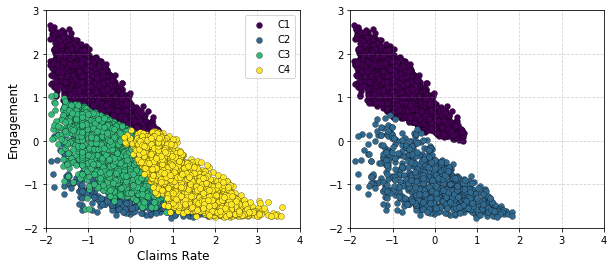

In [133]:
plot_clusters(df_kmeans, df_kmeans['consume_labels'].unique(), 'consume_labels', 'premium_house', 'premium_motor', 
              0,1, 'Claims Rate', 'Engagement', 'report\engage_salary_engagement',
              (-2,4), (-2,3), (-2,4), (-2,3))

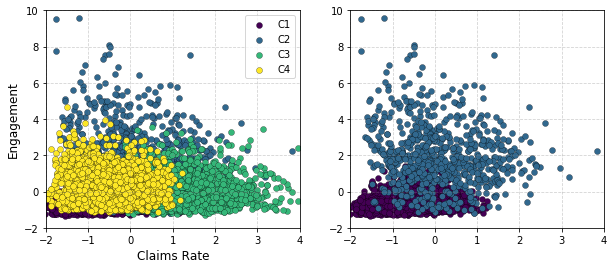

In [137]:
plot_clusters(df_kmeans, df_kmeans['consume_labels'].unique(), 'consume_labels', 'premium_health', 'premium_work', 
              0,1, 'Claims Rate', 'Engagement', 'report\engage_salary_engagement',
              (-2,4), (-2,10), (-2,4), (-2,10))

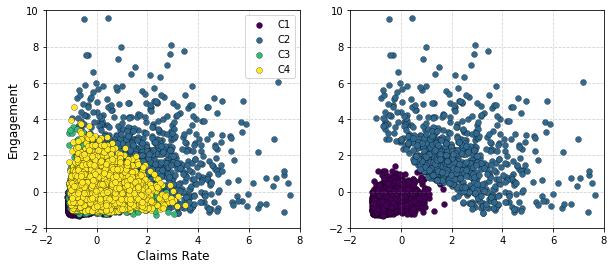

In [140]:
plot_clusters(df_kmeans, df_kmeans['consume_labels'].unique(), 'consume_labels', 'premium_life', 'premium_work', 
              0,1, 'Claims Rate', 'Engagement', 'report\engage_salary_engagement',
              (-2,8), (-2,10), (-2,8), (-2,10))

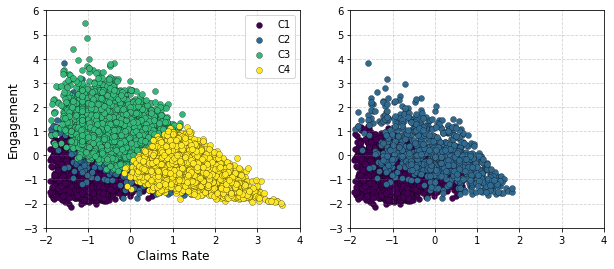

In [145]:
plot_clusters(df_kmeans, df_kmeans['consume_labels'].unique(), 'consume_labels', 'premium_house', 'premium_health', 
              0,1, 'Claims Rate', 'Engagement', 'report\engage_salary_engagement',
              (-2,4), (-3,6), (-2,4), (-3,6))

In [405]:
df_hierarchical.to_pickle('clusters_centroids.pkl')

In [626]:
df_categorical.to_pickle('df_categorical.pkl')

In [623]:
df_engagement.to_pickle('df_engagement_scaled.pkl')

In [624]:
df_consume.to_pickle('df_consume_scaled.pkl')